In [ ]:
!nvidia-smi

Sun Sep  6 04:28:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
prepro = transforms.Compose([transforms.Resize(64),transforms.ToTensor()])
tensor_to_pil = transforms.ToPILImage()

In [ ]:
mnist = datasets.MNIST(root='./MNIST',
                       train=True,
                       transform=prepro,
                       download=True)

In [ ]:
image, label = mnist[0]

In [ ]:
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size = 32,
                                          shuffle = True,
                                          num_workers = 2)

In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=100):
    super(Generator,self).__init__()
    self.z_dim = z_dim
    self.Deconv1 = nn.ConvTranspose2d(self.z_dim,1024,kernel_size=6,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(1024)
    self.Deconv2 = nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1)
    self.bn2 = nn.BatchNorm2d(512)
    self.Deconv3 = nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.Deconv4 = nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)
    self.bn4 = nn.BatchNorm2d(128)
    self.Deconv5 = nn.ConvTranspose2d(128,1,kernel_size=4,stride=2,padding=1)
    self.bn5 = nn.BatchNorm2d(1)
  
  def forward(self,z):
    z = z.view(z.size()[0],z.size()[1],1,1)
    h = F.relu(self.bn1(self.Deconv1(z)))
    h = F.relu(self.bn2(self.Deconv2(h)))
    h = F.relu(self.bn3(self.Deconv3(h)))
    h = F.relu(self.bn4(self.Deconv4(h)))
    h = F.relu(self.bn5(self.Deconv5(h)))

    image = F.tanh(h)
    
    return image

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, image_size=784):
    super(Discriminator, self).__init__()
    self.Conv2d1 = nn.Conv2d(1,64,4,2,1);
    self.Conv2d2 = nn.Conv2d(64,128,4,2,1);
    self.BN2 = nn.BatchNorm2d(128);
    self.Conv2d3 = nn.Conv2d(128,256,4,2,1);
    self.BN3 = nn.BatchNorm2d(256);
    self.Conv2d4 = nn.Conv2d(256,512,4,2,1);
    self.BN4 = nn.BatchNorm2d(512);
    self.Conv2d5 = nn.Conv2d(512,1,4,1,0);
    self.LR = nn.LeakyReLU(0.2,inplace=True);

  def forward(self, f_image):
    h = self.LR(self.Conv2d1(f_image))
    h = self.LR(self.BN2(self.Conv2d2(h)))
    h = self.LR(self.BN3(self.Conv2d3(h)))
    h = self.LR(self.BN4(self.Conv2d4(h)))
    prob_real = F.sigmoid(self.Conv2d5(h))

    return prob_real.view(prob_real.size()[0],1)

In [ ]:
G = Generator().cuda()

In [ ]:
D = Discriminator().cuda()

In [ ]:
z = Variable(torch.randn(32,100))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


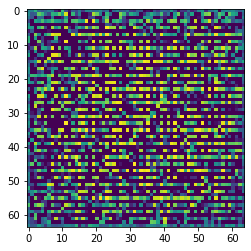

In [ ]:
fake_image = G(z.cuda())
fake_image.size()
plt.imshow(fake_image.view(32,64,64)[0].cpu().detach())

In [ ]:
fake_image.size()

torch.Size([32, 1, 64, 64])

In [ ]:
prob = D(fake_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
# Define optimizer
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0002)

In [ ]:
batch_size = 32
z_dim = 100

In [ ]:
criterion = nn.BCELoss()

In [ ]:
D.cuda()
G.cuda()

Generator(
  (Deconv1): ConvTranspose2d(100, 1024, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Deconv5): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
# BCE Loss =  -y*log(x)-(1-y)*log(1-x)
# y = 1 -> -log(x)
# y = 0 -> -log(1-x)

logD(x)가 최대가 되어야한다.
Real image에 대해서는 0부터 1사이의 probability 값 중 당연히 1에 가까운 값이 되어야한다.
log함수의 경우 0~1의 x축에서 1에 가까워질수록 커짐.
Maximization -> -를 붙여줘야한다. (optimization은 기본적으로 minimize라)

Fake image 0에 가까운 값. log(1-x)는 0에서 최대.

In [ ]:
for epoch in range(100):
  for i, (images, _) in enumerate(data_loader):
    ### Train D ###
    images = Variable(images).cuda()
    
    z = Variable(torch.randn(batch_size, z_dim)).cuda()
    real_labels = Variable(torch.ones(batch_size)).cuda()
    fake_labels = Variable(torch.zeros(batch_size)).cuda()

    ### train with real image
    prob = D(images)
    real_loss = criterion(prob,real_labels)
    #real_label은 1, 따라서 -r*log(p)-(1-r)*log(1-p)=-log(p)

    #log_prob = -torch.mean(torch.log(prob))

    ### train with fake image

    fake_image = G(z)
    prob = D(fake_image)
    fake_loss = criterion(prob,fake_labels)
    #fake_label은 0, 따라서 -r*log(p)-(1-r)*log(1-p)=-log(1-p)

    d_loss = real_loss + fake_loss # real, fake에 대해 각각 1, 0을 만들도록
    d_optimizer.zero_grad()
    #zero_grad : we need to set the gradients to zero before starting to do backprop because 
#pytorch accumulates the gradients on subsequent backward passes. This is convenient while training RNNs.
#So the default action is to accumulate the gradients on every loss.backward() call.
    d_loss.backward()
    d_optimizer.step()

    ### Train G ###

    ### train with fake image
    #geneartor 학습시에는 또다른 z를 생성. 
    #좀전에 가짜라고 한걸 진짜라고 하는것보다 다른 z를 sampling 하는게 좋음
    z = Variable(torch.randn(batch_size, z_dim)).cuda()
    fake_image = G(z)
    prob = D(fake_image)
    g_loss = criterion(prob,real_labels) # fake image를 real로 구분하도록

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if i % 100 == 0:
      print('\rEpoch %d, step %d, d_loss %.4f, g_loss %.4f'
            %(epoch+1,i+1,d_loss.data,g_loss.data),end='');
    if( i % 100 == 0 ):
      fake_image = fake_image.view(batch_size,1, 64, 64)
      sample_path = 'samples'#fake_img'+str(i)+'.jpg'
      if not os.path.exists(sample_path):
        os.makedirs(sample_path)
      plt.figure(figsize=(5,10))
      for ii in range(32):
        plt.subplot(8,4,ii+1)
        plt.imshow(fake_image[ii][0].cpu().detach().numpy())
      plt.savefig(sample_path+'/fake_image%2d_%2d.png'%(epoch,i))
      plt.close("all")
      
  if (epoch+1) % 10 == 0 :
    if not os.path.exists('models'):
      os.makedirs('models')
    torch.save(D,'models/discriminator_%3d.pt'%(epoch+1))
    torch.save(G,'models/generator_%3d.pt'%(epoch+1))
       


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 7, step 1, d_loss 0.0686, g_loss 2.8393